In [1]:
!pip3 install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=548773 sha256=3ea1f28e475933dfd9c5bece69733dae7f08ac8e51f202729f6641949ea98f2b
  Stored in directory: c:\users\hahih\appdata\local\pip\cache\wheels\da\a4\bb\dbed5db92b2183a753dd96cc8a56706a61484ff3959988bdaa
Successfully built fbprophet


In [24]:
import pandas as pd
from fbprophet import Prophet
from datetime import datetime as dt

##データの前処理
#東京電力のサイトから電力需要（年ごと）の読み込み
years = [2017, 2018, 2019]
# year = years[0]
df = pd.DataFrame()

for year in years:
    url = f'https://www.tepco.co.jp/forecast/html/images/juyo-{year}.csv'
    _df =pd.read_csv(url, encoding='shift-JIS',skiprows=1)
    df = pd.concat([df, _df], axis=0)

df = df.reset_index(drop=True)

#時間のインデックスを整理する
datetimes = []
for index, datum in df.iterrows():
    date = datum['DATE']
    time = datum['TIME']
    str_datetime = f'{date} {time}'
    datetime = dt.strptime(str_datetime, '%Y/%m/%d %H:%M')
    datetimes.append(datetime)

df['ds'] = datetimes#新たなカラムDSを追加
df = df.rename(columns={'実績(万kW)': 'y'})#実績をyというカラムに

df

,DATE,TIME,y,ds
0,2017/1/1,0:00,2783,2017-01-01 00:00:00
1,2017/1/1,1:00,2634,2017-01-01 01:00:00
2,2017/1/1,2:00,2520,2017-01-01 02:00:00
3,2017/1/1,3:00,2438,2017-01-01 03:00:00
4,2017/1/1,4:00,2389,2017-01-01 04:00:00
...,...,...,...,...
26275,2019/12/31,19:00,3302,2019-12-31 19:00:00
26276,2019/12/31,20:00,3263,2019-12-31 20:00:00
26277,2019/12/31,21:00,3182,2019-12-31 21:00:00
26278,2019/12/31,22:00,3077,2019-12-31 22:00:00


<function matplotlib.pyplot.show(close=None, block=None)>

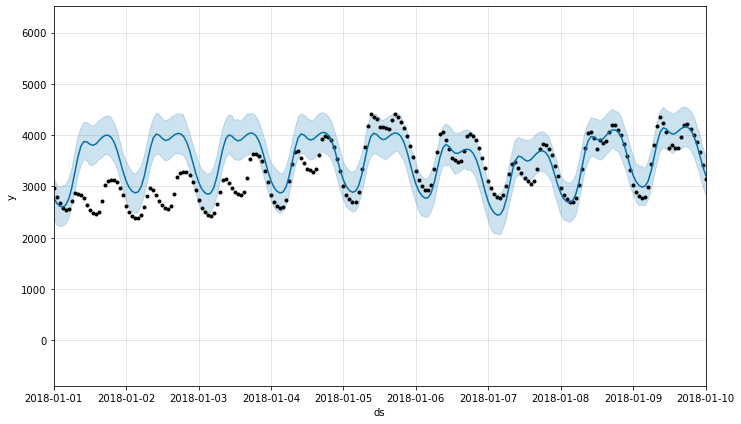

In [35]:
##モデルの作成と予測値の算出
import matplotlib.pyplot as plt

model = Prophet()
model.fit(df)
future = model.make_future_dataframe(24*366, freq='H')#2020年分の箱を作成
forecast = model.predict(future)

model.plot(forecast)
plt.xlim(dt(2018, 1, 1), dt(2018, 1, 10))
plt.show

In [41]:
##実際の2020年の値と比較

url2 = f'https://www.tepco.co.jp/forecast/html/images/juyo-2020.csv'
df_2020 =pd.read_csv(url2, encoding='shift-JIS',skiprows=1)
df_2020 = df_2020.rename(columns={'実績(万kW)': 'y'})
forecast_2020 = forecast[forecast['ds'] >= dt(2020,1, 1)].reset_index(drop=True)

results = pd.DataFrame()
#実測値
results['t'] = df_2020['y']
#予測値
results['y'] = forecast_2020['yhat']
results['diff'] = results['t'] - results['y']

results.head()

,t,y,diff
0,2857,2910.586550,-53.586550
1,2703,2780.857029,-77.857029
2,2602,2703.197905,-101.197905
3,2520,2669.257691,-149.257691
4,2464,2688.947548,-224.947548


In [42]:
import numpy as np

In [43]:
#誤差率の算出
np.mean(abs((results['y'] - results['t'] ) / results['y']) * 100)

11.483259244486415

In [45]:
#精度向上
df_holidays = pd.read_csv('holidays+hotdays+hour_2017_2019.csv')

In [46]:
df.y.max()

5653

In [47]:
df['cap'] = 5700

In [48]:
model = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    holidays=df_holidays
    )

In [49]:
model.fit(df)

<function matplotlib.pyplot.show(close=None, block=None)>

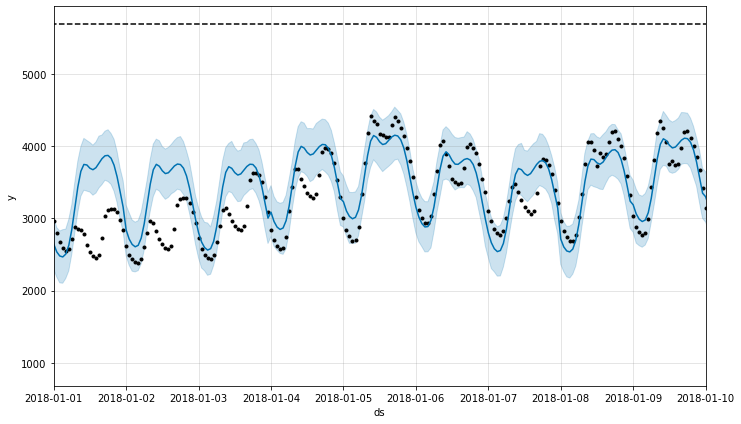

In [50]:
future['cap'] = 5700
forecast = model.predict(future)

model.plot(forecast)
plt.xlim(dt(2018, 1, 1), dt(2018, 1, 10))
plt.show


In [51]:
forecast_2020 = forecast[forecast['ds'] >= dt(2020,1, 1)].reset_index(drop=True)

results = pd.DataFrame()
#実測値
results['t'] = df_2020['y']
#予測値
results['y'] = forecast_2020['yhat']
results['diff'] = results['t'] - results['y']

np.mean(abs((results['y'] - results['t'] ) / results['y']) * 100)



8.536100552867872

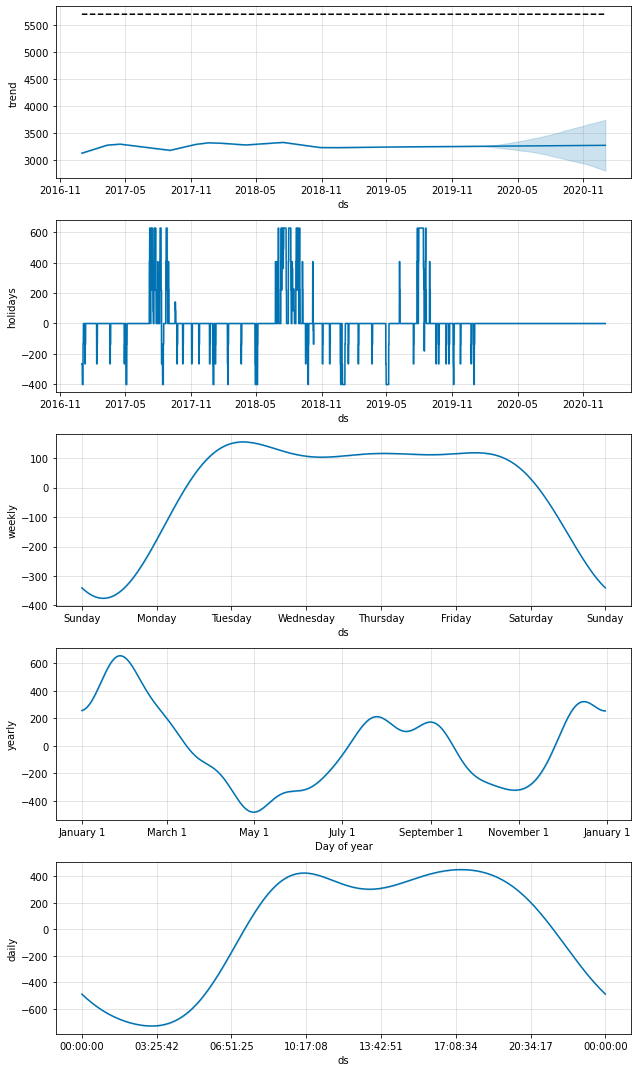

In [53]:
model.plot_components(forecast)
plt.show()